# CSCE 421 :: Machine Learning :: Texas A&M University :: Spring 2023

# Homework 6 (HW-6)
**Name:**  
**UIN:**  

# Convolutional Neural Networks

In this assignment, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary. 
- Once you've filled out your solutions, submit the notebook on Canvas.
- Do **NOT** forget to type in your name and UIN at the beginning of the notebook.

## Data Preparation

In [6]:
!pip install torchinfo

In [292]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [293]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [294]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

## Data Exploration

Let's take a look at the classes in our dataset.

In [295]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [296]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: Dress (3)


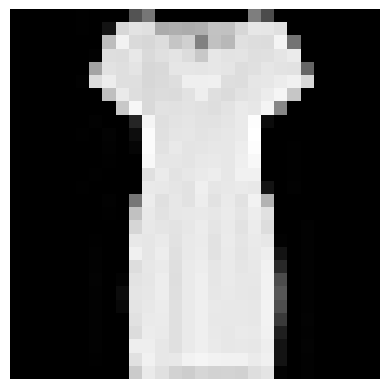

In [297]:
show_example(*dataset[20])

Label: Sneaker (7)


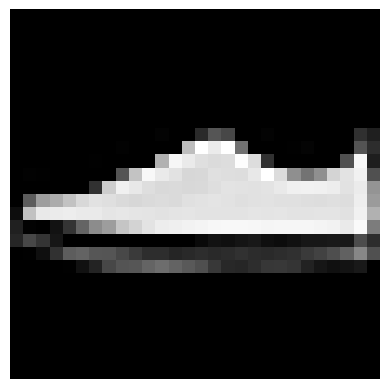

In [298]:
show_example(*dataset[20000])

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  

**Choose a suitable fraction for your validation set and experiment with the seed. Remember that the better your validation set, the higher the chances that your model would do well on the test set.**

In [299]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [300]:

val_frac =  0.20 ## Set the fraction for the validation set
rand_seed =  42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 48000
#samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

**Set the `batch_size` depending on the hardware resource (GPU/CPU RAM) you are using for the assignment.**

In [303]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [365]:
batch_size = 128

In [366]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [367]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


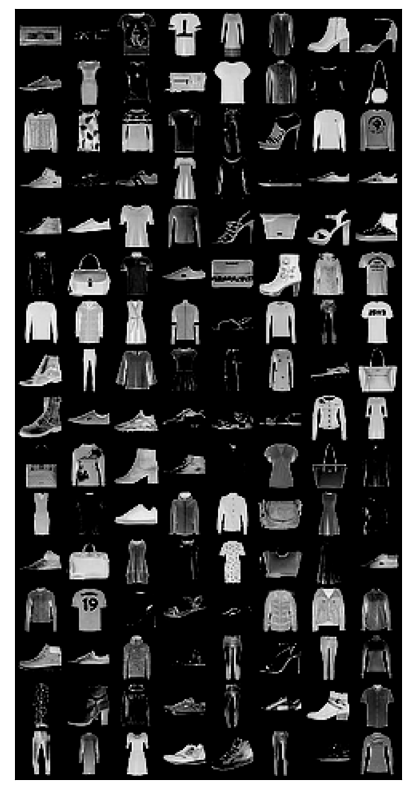

In [368]:
show_batch(train_dl)

## Building the Model

**Grading: 20 pts for Build the Model section \
They don't have to have the exact same model, e.g., the number of layers can be different, the parameters in the model \
The very first parameter of the first layer has to be 1 nn.Conv2d(1, ....), because this is black-white dataset, otherwise -5pts \
The very last parameter of the last layer has to be 10 nn.Linear(..., 10), otherwise -20pts. \
using nn.Conv1d (if ever happens) -20pts. \
no nn.MaxPool2d -10pts. \
If the total number of the parameters (should be printed below) is over 100,000, -10pts**

Create your model by defining the network architecture in the `ImageClassifierNet` class.  
**NOTE: The number of parameters in your network must be $\leq$ 100,000.**

In [576]:
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

In [548]:
# literally makes no sense to have color channels
class ImageClassifierNet(nn.Module):
    def __init__(self, classes=10):
        super(ImageClassifierNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.relu3 = nn.ReLU()

        self.dropout1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(128 * 2 * 2, 512)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(512, classes)
        
    def forward(self, X):
        X = self.conv1(X)
        X = self.relu1(X)
        X = self.conv2(X)
        X = self.relu2(X)
        X = self.conv3(X)
        X = self.relu3(X)

        X = X.view(X.size(0), -1)
        
        X = self.dropout1(X)
        X = self.linear1(X)
        X = self.relu4(X)
        X = self.dropout2(X)
        X = self.linear2(X)

        return X

In [549]:
classes = len(dataset.classes)
model = ImageClassifierNet(classes) 

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [550]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [128, 10]                 --
├─Conv2d: 1-1                            [128, 48, 13, 13]         480
├─ReLU: 1-2                              [128, 48, 13, 13]         --
├─Conv2d: 1-3                            [128, 64, 6, 6]           27,712
├─ReLU: 1-4                              [128, 64, 6, 6]           --
├─Conv2d: 1-5                            [128, 128, 2, 2]          73,856
├─ReLU: 1-6                              [128, 128, 2, 2]          --
├─Dropout: 1-7                           [128, 512]                --
├─Linear: 1-8                            [128, 512]                262,656
├─ReLU: 1-9                              [128, 512]                --
├─Dropout: 1-10                          [128, 512]                --
├─Linear: 1-11                           [128, 10]                 5,130
Total params: 369,834
Trainable params: 369,834
Non-trainable params

##Check Model Requirements status

Below code cell is to check if your model meets the requirements specefied 

Run the cell to check the status of your model

In [551]:
def check_model(model):
  first_layer = list(model.children())[0]
  last_layer  = list(model.children())[-1]
  num_params = sum(p.numel() for p in model.parameters())
  has_conv1d = False
  has_maxpool2d = False
  first_layer_status= False
  last_layer_status = False

  if isinstance(first_layer, nn.Sequential):
        if isinstance(first_layer[0], nn.Conv2d) and first_layer[0].in_channels == 1:
          first_layer_status= True
  else: 
    if isinstance(first_layer, nn.Conv2d) and first_layer.in_channels == 1:
      first_layer_status= True

  if isinstance(last_layer, nn.Sequential):
    if isinstance(last_layer[-1], nn.Linear) and last_layer[-1].out_features == 10:
      last_layer_status = True
  else:
    print(type(last_layer))
    if isinstance(last_layer, nn.Linear) and last_layer.out_features == 10:
      last_layer_status = True

  for layer in model.modules():
    if isinstance(layer, nn.Conv1d):
        has_conv1d = True
    if isinstance(layer, nn.MaxPool2d):
        has_maxpool2d = True
  flag = False
  if first_layer_status == False:
    print("The very first parameter of the first layer is not 1 nn.Conv2d(1, ....)")
    flag = True
  if last_layer_status == False:
    print("The very last parameter of the last layer is not 10 nn.Linear(..., 10)")
    flag = True
  if has_conv1d == True:
    print("Using nn.Conv1d, which should not happen")
    flag = True
  if has_maxpool2d == True: #was False
    print("No nn.MaxPool2d")
    flag = True
  if num_params > 100000:
    print("Parameters > 100000, please make the network less complex to recieve full grade")
  
  if flag == False:
    print("The Network looks good") 

check_model(model)

<class 'torch.nn.modules.linear.Linear'>
Parameters > 100000, please make the network less complex to recieve full grade
The Network looks good


In [552]:
print("IDC about parameters")

IDC about parameters


## Enable training on a GPU

**NOTE:** This section is necessary if you're training your model on a GPU.

In [553]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [554]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

cpu


ImageClassifierNet(
  (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (relu3): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

## Train the model

**Grading: the two cells below 20 pts \
Have to use both training set and validation set, if no validation set -15 pts \
In training part, zero_grad() needs to be before backward(), and backwards() need to be before step(), wrong order or missing one -20 \
If any of zero_grad(), backward(), or step() happens in validation, -10pts \
If MSE-related loss is used in loss_fn (the second cell), -15 pts**

Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on a validation set.

In [555]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(n_epochs):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        
        #Training data loss
        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)
            
            opt_fn.zero_grad()
            
            # Forwards
            outputs = model(x)
            _, pred = torch.max(outputs, 1)
            loss = loss_fn(outputs, y)
            
            # Backwards
            loss.backward()
            opt_fn.step()
            
            train_loss.append(loss.item())
            train_acc.append((pred == y).sum().item() / y.shape[0])

        train_losses.append(np.mean(train_loss))
        train_accuracies.append(np.mean(train_acc))
        
        #Validation data loss

        if len(val_dl) != 0:
            for x, y in val_dl:
                # Forwards
                outputs = model(x)
                _, pred = torch.max(outputs, 1)
                loss = loss_fn(outputs, y)

                val_loss.append(loss.item())
                val_acc.append((pred == y).sum().item() /  y.shape[0])

            val_losses.append(np.mean(val_loss))
            val_accuracies.append(np.mean(val_acc))

        
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(train_loss):.4f}, Validation Loss: {np.mean(val_loss):.4f}, Train Accuracy: {np.mean(train_acc):.4f}, Validation Accuracy: {np.mean(val_acc):.4f}')
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [556]:
num_epochs = 15 # Max number of training epochs
loss_fn = nn.CrossEntropyLoss() # Define the loss function
opt_fn = torch.optim.Adam(model.parameters()) # Select an optimizer
lr = 0.001 # Set the learning rate

**Grading: results 20 pts \
The final train_accuracy and val_accuracy both need to above 0.9 \
0.85 t0 0.9  -5pts \
0.80 to 0.85 -15pts \
below 0.80 -20 pts**

In [557]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch 1/15, Train Loss: 0.6210, Validation Loss: 0.4478, Train Accuracy: 0.7714, Validation Accuracy: 0.8305
Epoch 2/15, Train Loss: 0.4047, Validation Loss: 0.4001, Train Accuracy: 0.8505, Validation Accuracy: 0.8576
Epoch 3/15, Train Loss: 0.3473, Validation Loss: 0.3513, Train Accuracy: 0.8703, Validation Accuracy: 0.8688
Epoch 4/15, Train Loss: 0.3123, Validation Loss: 0.3600, Train Accuracy: 0.8832, Validation Accuracy: 0.8661
Epoch 5/15, Train Loss: 0.2846, Validation Loss: 0.3178, Train Accuracy: 0.8950, Validation Accuracy: 0.8870
Epoch 6/15, Train Loss: 0.2586, Validation Loss: 0.3092, Train Accuracy: 0.9035, Validation Accuracy: 0.8887
Epoch 7/15, Train Loss: 0.2401, Validation Loss: 0.3042, Train Accuracy: 0.9116, Validation Accuracy: 0.8897
Epoch 8/15, Train Loss: 0.2232, Validation Loss: 0.3044, Train Accuracy: 0.9170, Validation Accuracy: 0.8888
Epoch 9/15, Train Loss: 0.2070, Validation Loss: 0.3092, Train Accuracy: 0.9235, Validation Accuracy: 0.8923
Epoch 10/15, Train 

## Plot loss and accuracy

In [558]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

**Grading: 10 pts for the first figure
Both training and validation need to go up \
It's okay if validation is not stable as long as it roughly goes up \
Any of them apparently goes down -10pts**

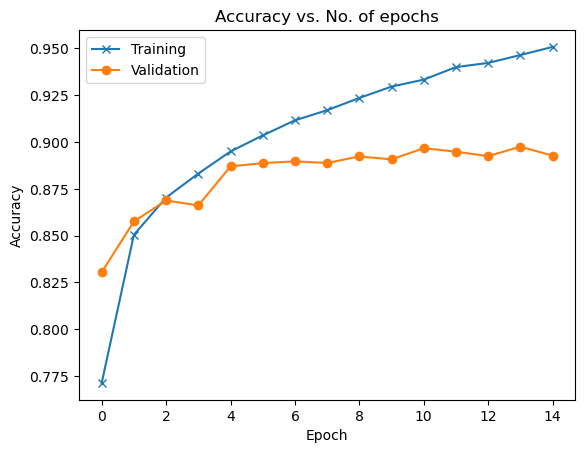

In [559]:
plot_accuracy(train_accuracies, val_accuracies)

In [560]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

**Grading: 10 pts for the second figure
Both training and validation need to go down \
Again, it's okay if validation is not stable or going down first then going up \
If training apparently goes up, -10pts \
If validation goes up from the beginning, -5pts**

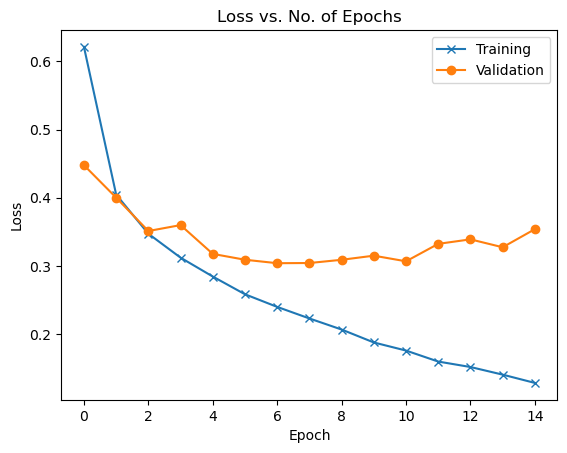

In [561]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

We create a new model with same architecture and train it on the whole training data.

In [562]:
new_model = ImageClassifierNet(10)


**NOTE:** The next cell is necessary if you're training your new_model on a GPU.

In [563]:
to_device(new_model, device)

ImageClassifierNet(
  (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (relu3): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

In [564]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

**Grading**: results 10 pts\
The final Train_accuracy needs to above 0.9
*  0.85 to 0.9 -3pts
*  0.80 to 0.85 -5pts
*  below 0.80 -10 pts

In [565]:

num_epochs = 15# Max number of training epochs
lr = 0.05# Set the learning rate
opt_fn = torch.optim.Adam(new_model.parameters()) # Select an optimizer

history = train_model(num_epochs, new_model, dl, [], loss_fn, opt_fn, lr)
new_model = history[0]

Epoch 1/15, Train Loss: 0.5890, Validation Loss: nan, Train Accuracy: 0.7828, Validation Accuracy: nan
Epoch 2/15, Train Loss: 0.3937, Validation Loss: nan, Train Accuracy: 0.8536, Validation Accuracy: nan
Epoch 3/15, Train Loss: 0.3393, Validation Loss: nan, Train Accuracy: 0.8734, Validation Accuracy: nan
Epoch 4/15, Train Loss: 0.3031, Validation Loss: nan, Train Accuracy: 0.8878, Validation Accuracy: nan
Epoch 5/15, Train Loss: 0.2737, Validation Loss: nan, Train Accuracy: 0.8981, Validation Accuracy: nan
Epoch 6/15, Train Loss: 0.2539, Validation Loss: nan, Train Accuracy: 0.9041, Validation Accuracy: nan
Epoch 7/15, Train Loss: 0.2323, Validation Loss: nan, Train Accuracy: 0.9135, Validation Accuracy: nan
Epoch 8/15, Train Loss: 0.2168, Validation Loss: nan, Train Accuracy: 0.9194, Validation Accuracy: nan
Epoch 9/15, Train Loss: 0.2013, Validation Loss: nan, Train Accuracy: 0.9257, Validation Accuracy: nan
Epoch 10/15, Train Loss: 0.1868, Validation Loss: nan, Train Accuracy: 0.

## Check Predictions

In [566]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

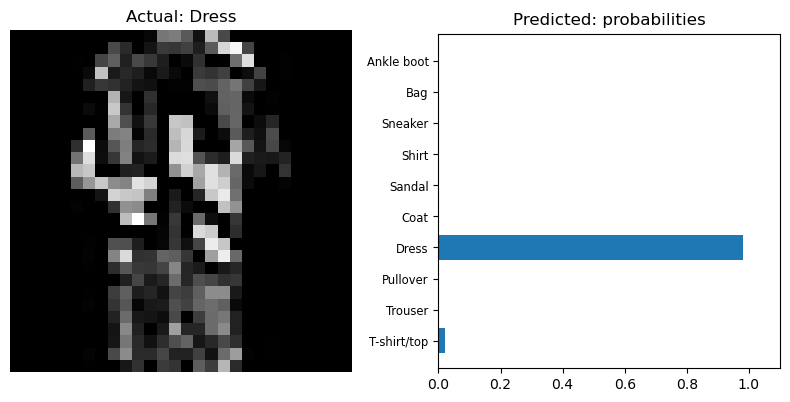

In [579]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        new_model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(new_model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save the model

In [568]:
torch.save(new_model, 'new_model')

## Compute accuracy on the test set

Here we load the test data pickle file provided.

You need to provide the path for the test_data pickle file and run the cells.

Note: Your score will be given based on your model's performance on a test data set hidden from you. But you can expect similar results from both the test data set provided to you ans the one hidden from you.

**Grading**: results 10 pts\
The final Test_accuracy needs to above 0.9
*  0.85 to 0.9 -3pts
*  0.80 to 0.85 -5pts
*  below 0.80 -10 pts


In [580]:
import pickle

In [581]:
test_dataset_file_path = "test_data.pickle"

with open(test_dataset_file_path, 'rb') as f:
    test_dataset = pickle.load(f)

In [582]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [583]:
def evaluate(model, test_dl):
    with torch.no_grad():
        model.eval()
        total_test_dl = 0
        preds, labels = [], []
        for xb, yb in test_dl:
            # Model output
            y_pred = model(xb)
            _, y_pred = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            labels.extend(yb)               
            total_test_dl += len(yb)

    preds, labels = torch.tensor(preds), torch.tensor(labels)
    test_accuracy = torch.sum(preds == labels).item() / len(preds)
    return test_accuracy

In [584]:
print("Test Accuracy = {:.4f}".format(evaluate(new_model, test_dl)))

Test Accuracy = 0.9092
